In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io, sys, os, textwrap


CSV_PATH = "Student_performance_data _.csv"
DISPLAY_ROWS = 5
TOP_N_CATS = 10
RANDOM_SEED = 42

# ---------- Helpers ----------
def clean_columns(df):
    df = df.copy()
    df.columns = (
        df.columns
        .str.strip()
        .str.replace(r"\s+", "_", regex=True)
        .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
        .str.lower()
    )
    return df

def detect_types(df):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
    return num_cols, cat_cols

def missing_table(df):
    miss = df.isna().sum()
    pct = df.isna().mean() * 100
    out = pd.DataFrame({"missing": miss, "missing_pct": pct}).sort_values("missing_pct", ascending=False)
    return out

def cat_summary(df, cat_cols, top_n=TOP_N_CATS):
    rows = []
    for c in cat_cols:
        vc = df[c].astype("string").value_counts(dropna=False).head(top_n)
        rows.append({
            "column": c,
            "n_unique": df[c].nunique(dropna=True),
            "top_values": "; ".join([f"{k}={v}" for k, v in vc.items()])
        })
    return pd.DataFrame(rows)

def safe_show_df(df, name=None, max_rows=DISPLAY_ROWS):
    # Pretty print without overflowing
    print(f"\n{name or 'DataFrame'} (head):")
    print(df.head(max_rows))

def save_or_show(fig, title):
    fig.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

def find_target(df, num_cols):
    # Guess a target score column if present
    candidates = [c for c in num_cols if any(k in c for k in ["score", "math", "reading", "writing", "gpa", "grade", "exam", "performance", "total"])]
    if not candidates:
        return None
    # pick the most variable candidate
    return sorted(candidates, key=lambda c: df[c].std(skipna=True), reverse=True)[0]

In [7]:
df_raw = pd.read_csv(CSV_PATH)
df = clean_columns(df_raw)

print("Shape:", df.shape)
print("\nColumns:", list(df.columns))
safe_show_df(df, "Data")

Shape: (2392, 15)

Columns: ['studentid', 'age', 'gender', 'ethnicity', 'parentaleducation', 'studytimeweekly', 'absences', 'tutoring', 'parentalsupport', 'extracurricular', 'sports', 'music', 'volunteering', 'gpa', 'gradeclass']

Data (head):
   studentid  age  gender  ethnicity  parentaleducation  studytimeweekly  \
0       1001   17       1          0                  2        19.833723   
1       1002   18       0          0                  1        15.408756   
2       1003   15       0          2                  3         4.210570   
3       1004   17       1          0                  3        10.028829   
4       1005   17       1          0                  2         4.672495   

   absences  tutoring  parentalsupport  extracurricular  sports  music  \
0         7         1                2                0       0      1   
1         0         0                1                0       0      0   
2        26         0                2                0       0      0   
3  

In [8]:
# ---------- Basic info ----------
print("\nDtypes:")
print(df.dtypes)

print("\nDuplicate rows:", df.duplicated().sum())

mt = missing_table(df)
safe_show_df(mt, "Missing values by column", max_rows=20)
# No hay ningun dato faltante por lo que no hace falta imputar datos ni borrar observaciones


Dtypes:
studentid              int64
age                    int64
gender                 int64
ethnicity              int64
parentaleducation      int64
studytimeweekly      float64
absences               int64
tutoring               int64
parentalsupport        int64
extracurricular        int64
sports                 int64
music                  int64
volunteering           int64
gpa                  float64
gradeclass           float64
dtype: object

Duplicate rows: 0

Missing values by column (head):
                   missing  missing_pct
studentid                0          0.0
age                      0          0.0
gender                   0          0.0
ethnicity                0          0.0
parentaleducation        0          0.0
studytimeweekly          0          0.0
absences                 0          0.0
tutoring                 0          0.0
parentalsupport          0          0.0
extracurricular          0          0.0
sports                   0          0.0
music    

Todos los datos son numericos


Numeric columns: ['studentid', 'age', 'gender', 'ethnicity', 'parentaleducation', 'studytimeweekly', 'absences', 'tutoring', 'parentalsupport', 'extracurricular', 'sports', 'music', 'volunteering', 'gpa', 'gradeclass']
Categorical columns: []

Numeric summary (head):
                    count         mean         std     min      25%     50%  \
studentid          2392.0  2196.500000  690.655244  1001.0  1598.75  2196.5   
age                2392.0    16.468645    1.123798    15.0    15.00    16.0   
gender             2392.0     0.510870    0.499986     0.0     0.00     1.0   
ethnicity          2392.0     0.877508    1.028476     0.0     0.00     0.0   
parentaleducation  2392.0     1.746237    1.000411     0.0     1.00     2.0   

                       75%     max  
studentid          2794.25  3392.0  
age                  17.00    18.0  
gender                1.00     1.0  
ethnicity             2.00     3.0  
parentaleducation     2.00     4.0  


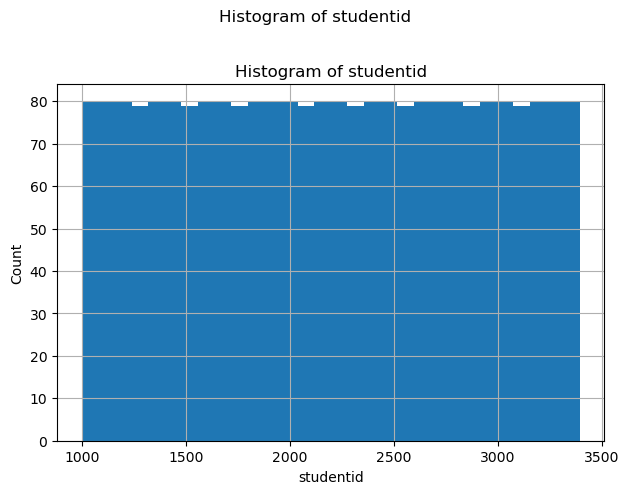

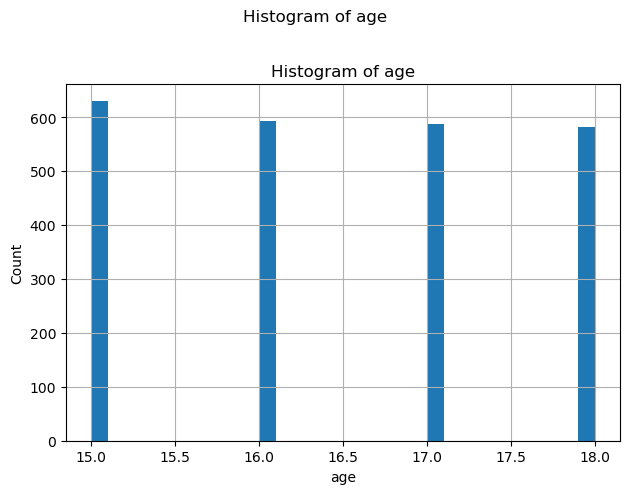

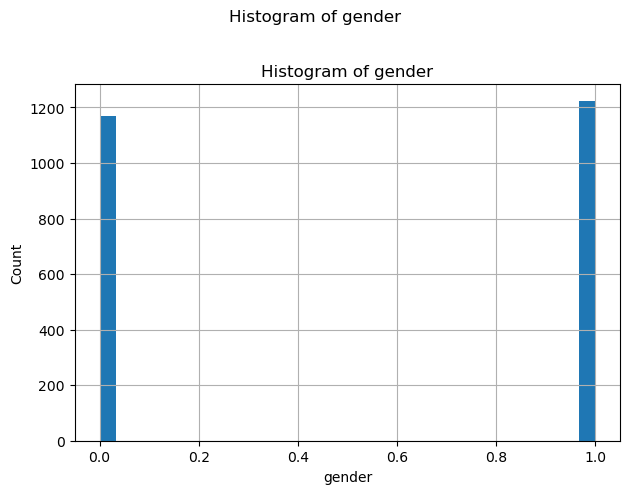

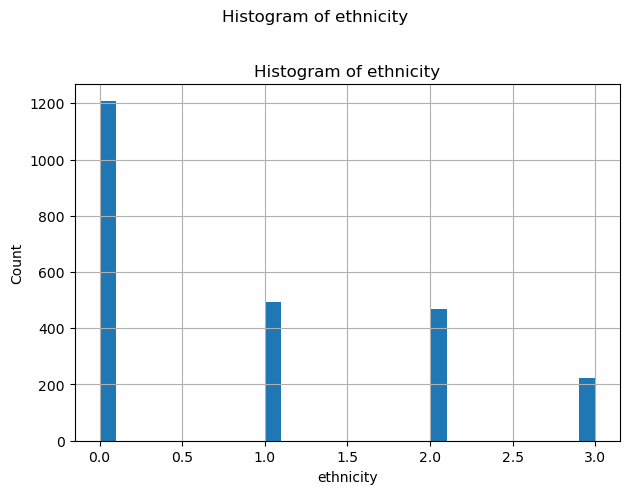

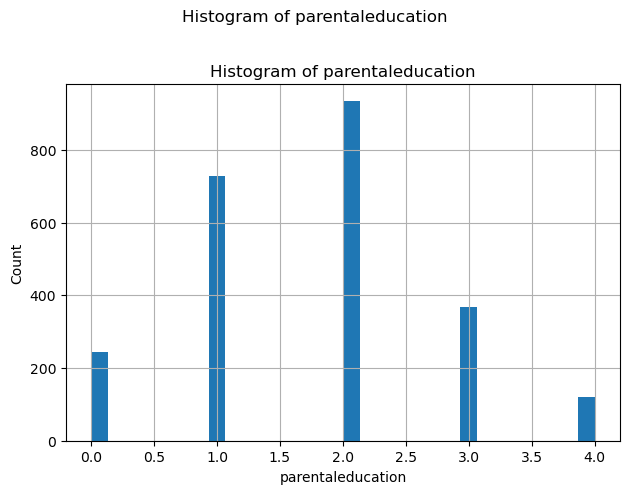

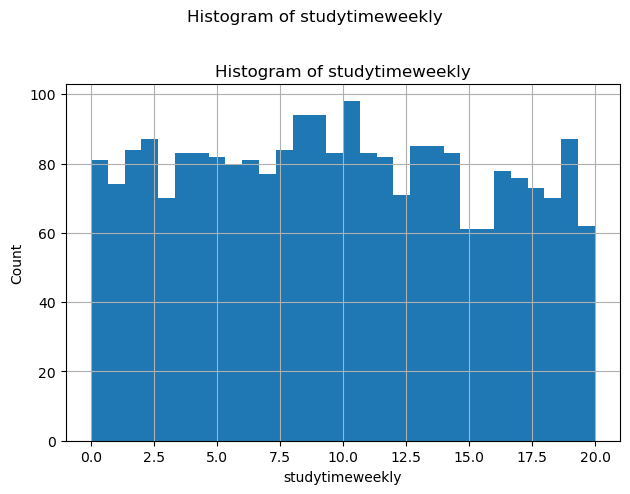

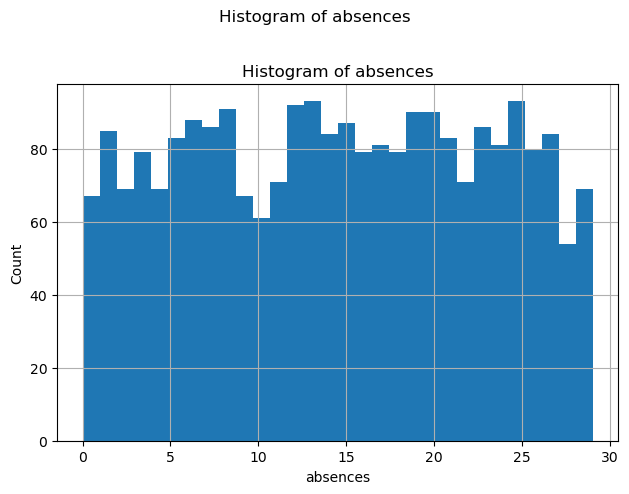

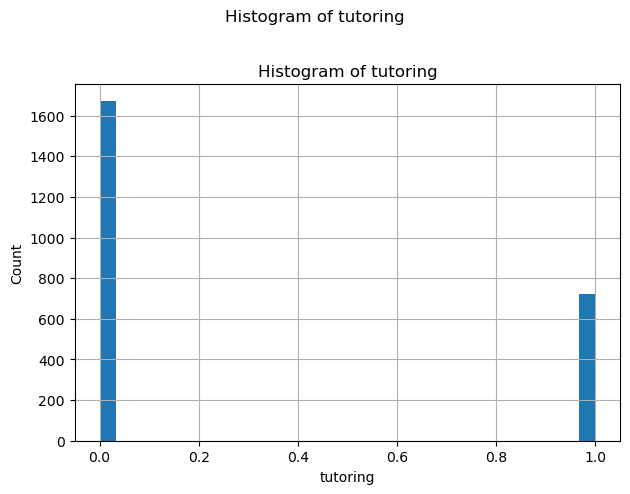

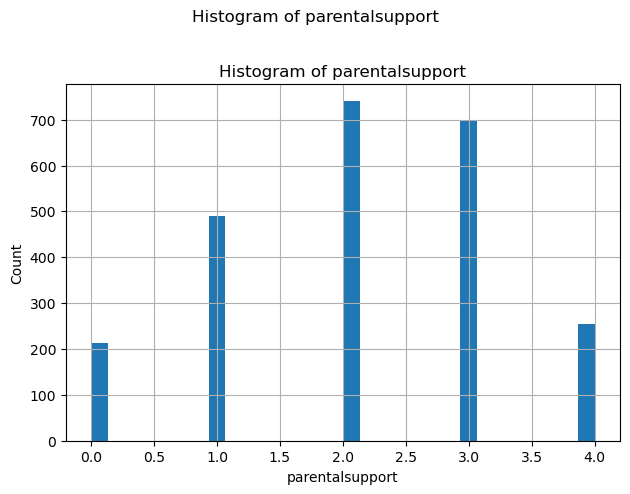

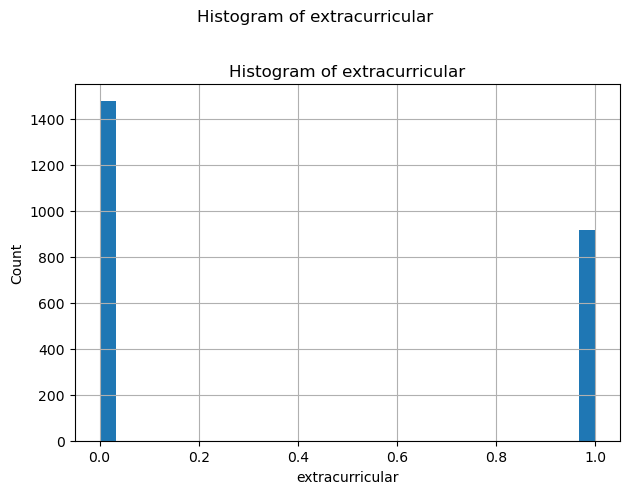

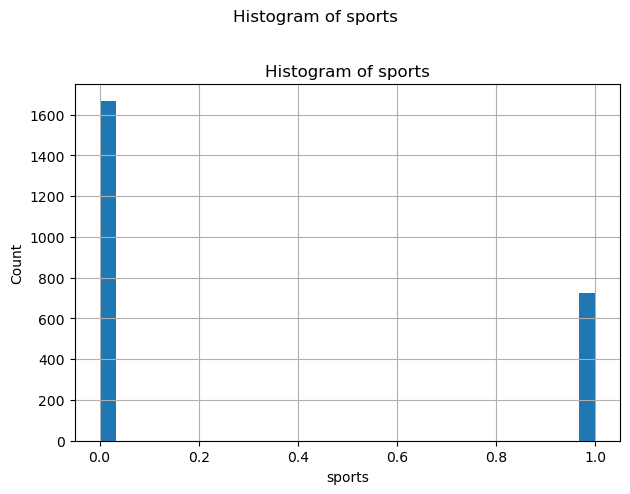

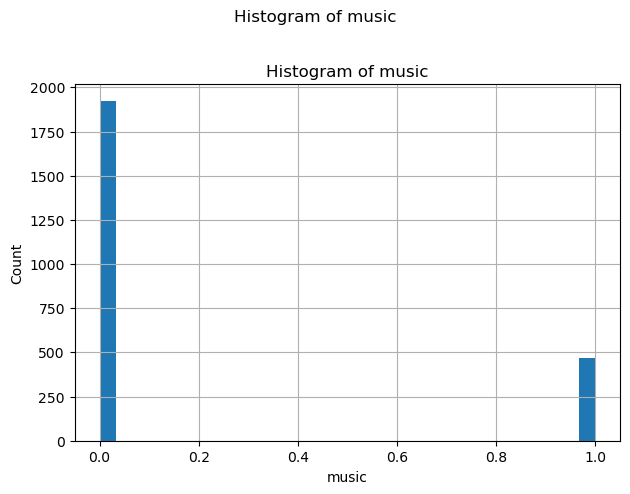

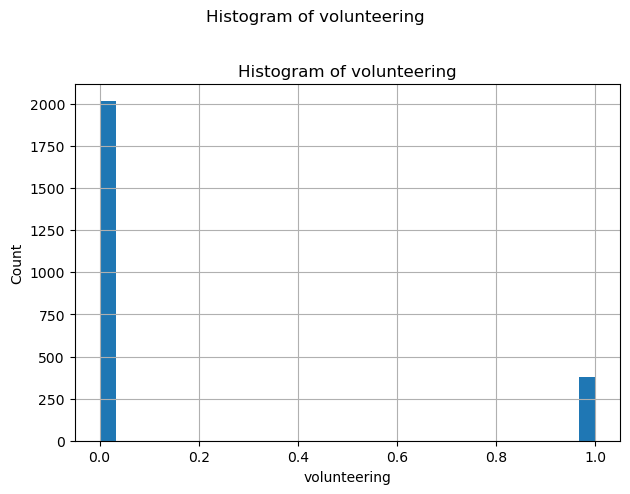

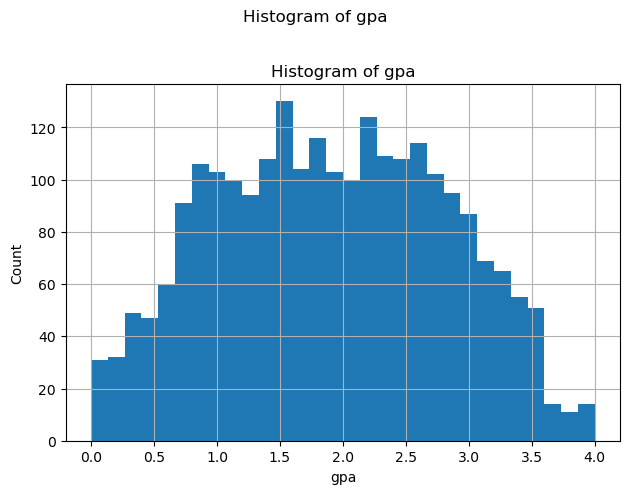

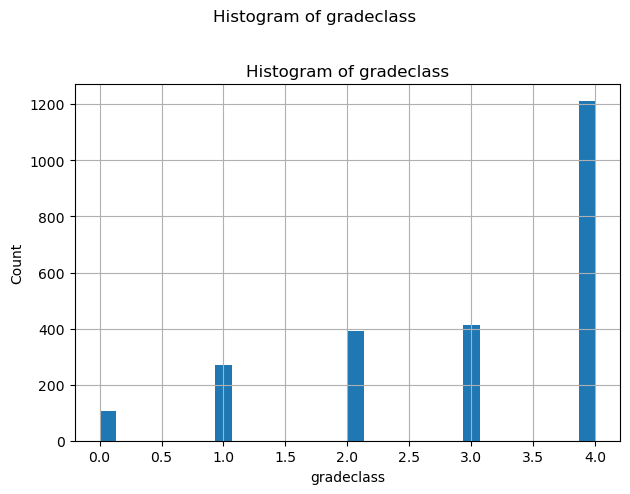

In [9]:

# ---------- Type splits ----------
num_cols, cat_cols = detect_types(df)
print("\nNumeric columns:", num_cols)
print("Categorical columns:", cat_cols)

if num_cols:
    desc_num = df[num_cols].describe().T
    safe_show_df(desc_num, "Numeric summary")

if cat_cols:
    desc_cat = cat_summary(df, cat_cols, TOP_N_CATS)
    safe_show_df(desc_cat, "Categorical summary")


# ---------- Distributions ----------
if num_cols:
    for c in num_cols:
        fig = plt.figure()
        df[c].hist(bins=30)
        plt.title(f"Histogram of {c}")
        plt.xlabel(c)
        plt.ylabel("Count")
        save_or_show(fig, f"Histogram of {c}")

if cat_cols:
    for c in cat_cols:
        vc = df[c].astype("string").value_counts().head(TOP_N_CATS)
        fig = plt.figure(figsize=(6, 3 + 0.2*len(vc)))
        vc.sort_values(ascending=True).plot(kind="barh")
        plt.title(f"Top {min(TOP_N_CATS, len(vc))} categories in {c}")
        plt.xlabel("Count")
        save_or_show(fig, f"Bar chart of {c}")


GPA parece tener una distribución normal

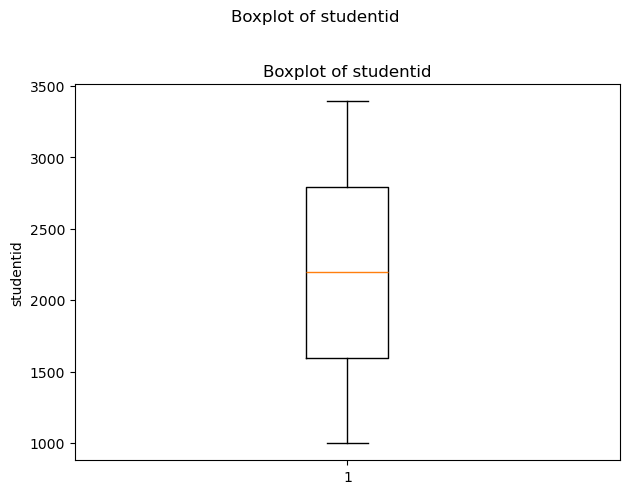

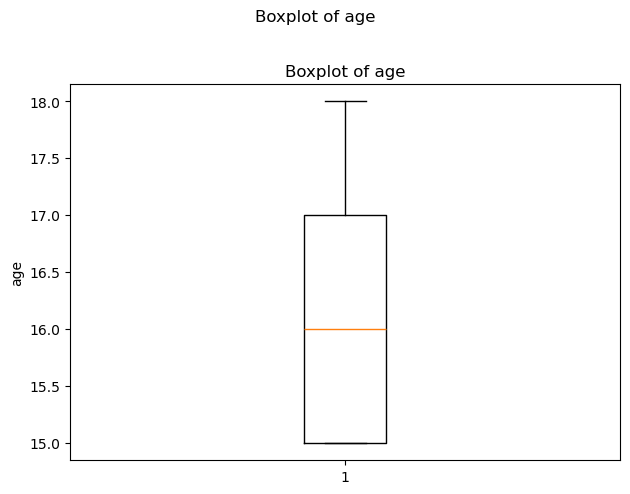

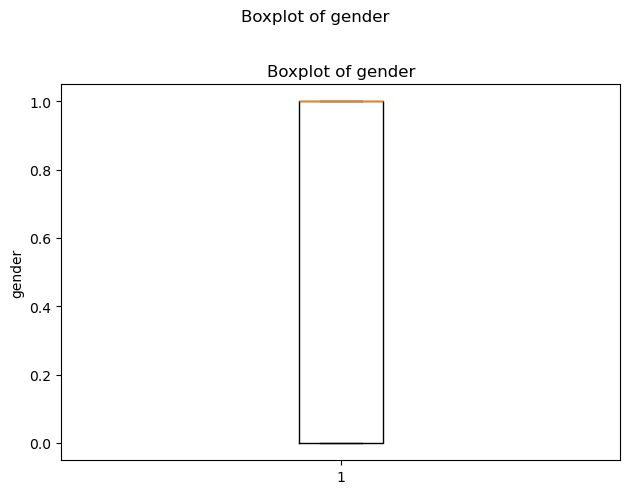

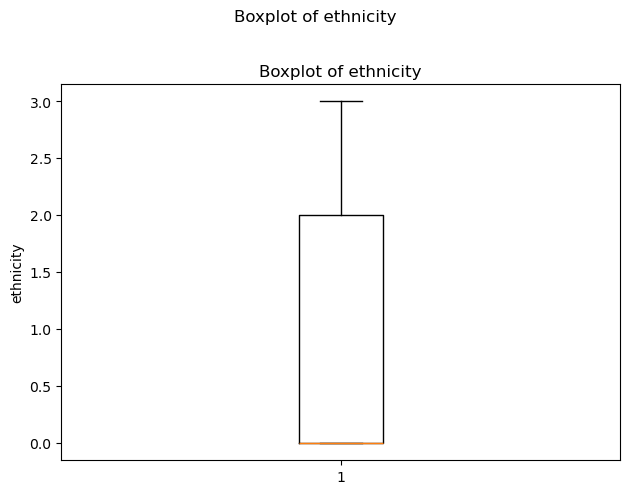

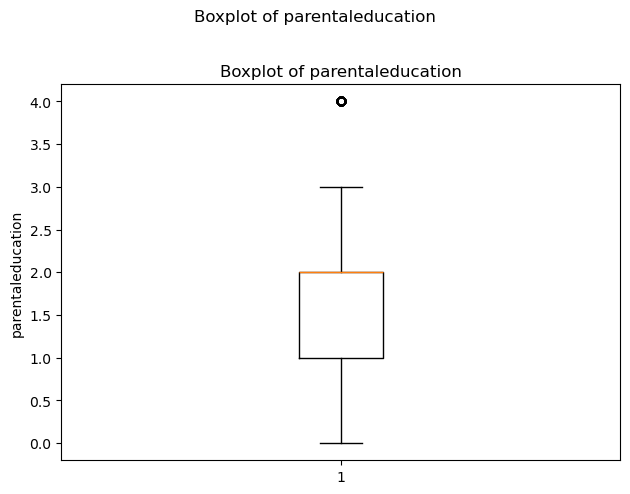

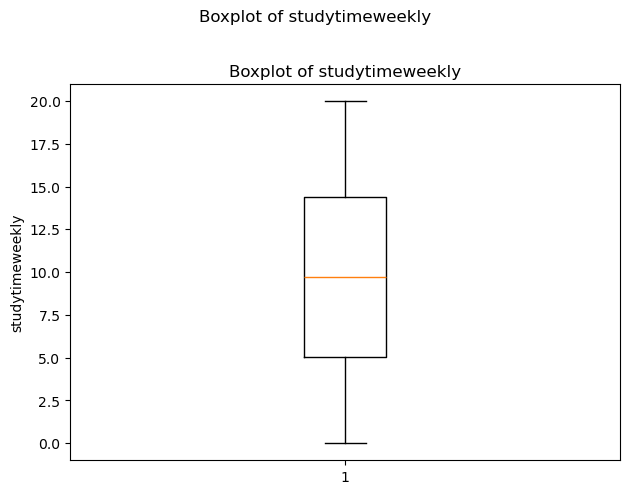

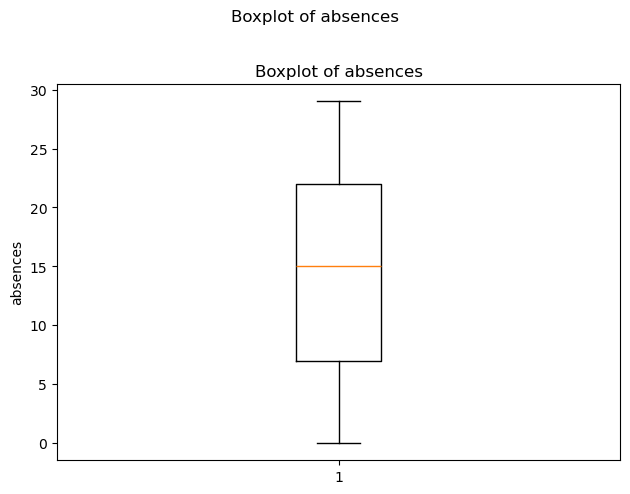

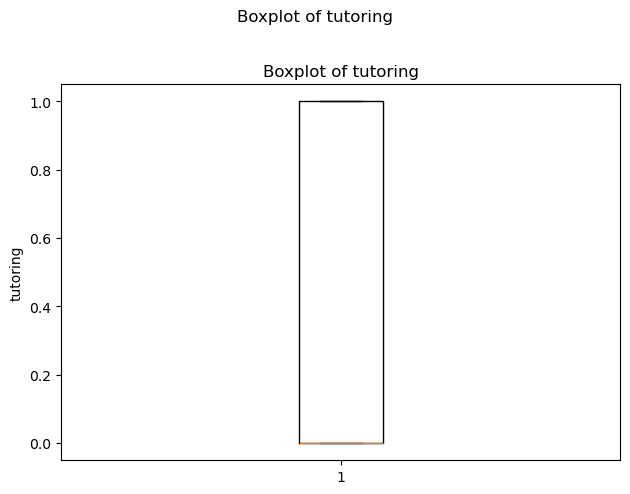

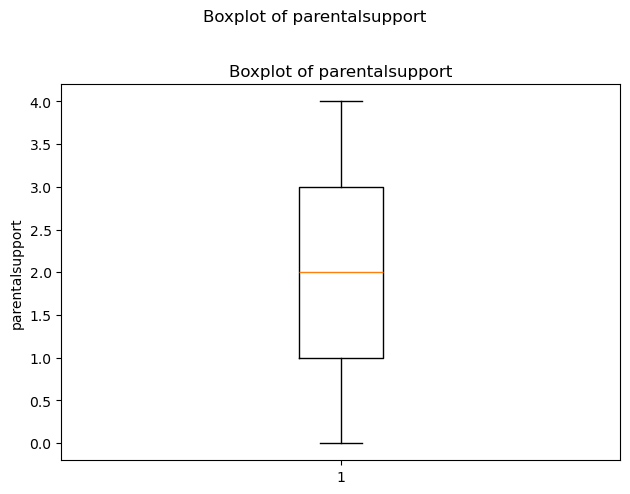

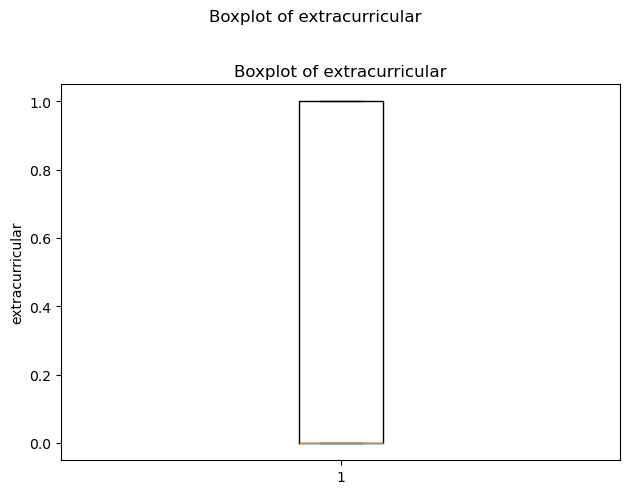

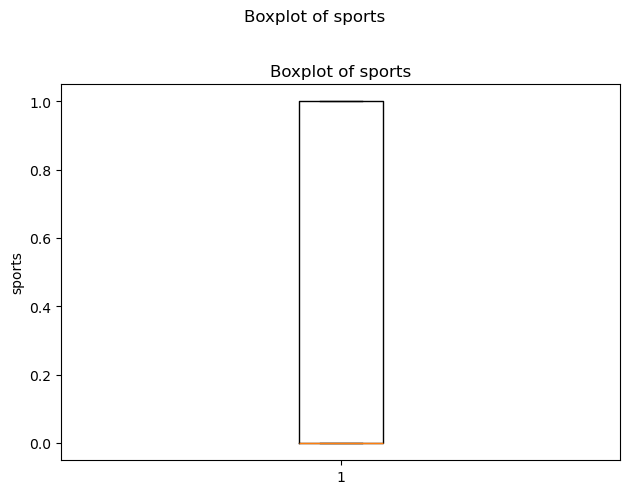

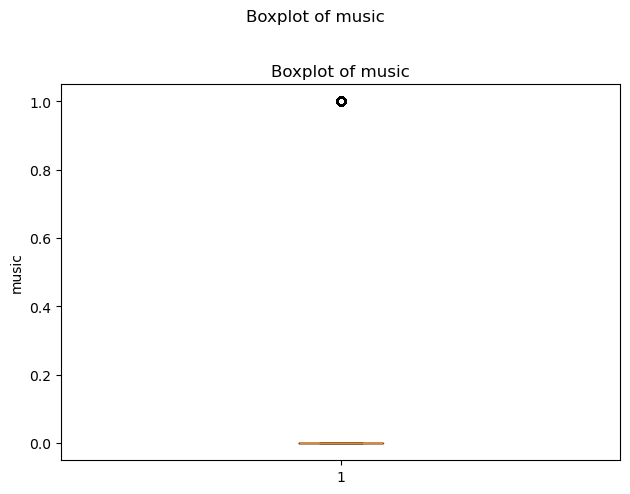

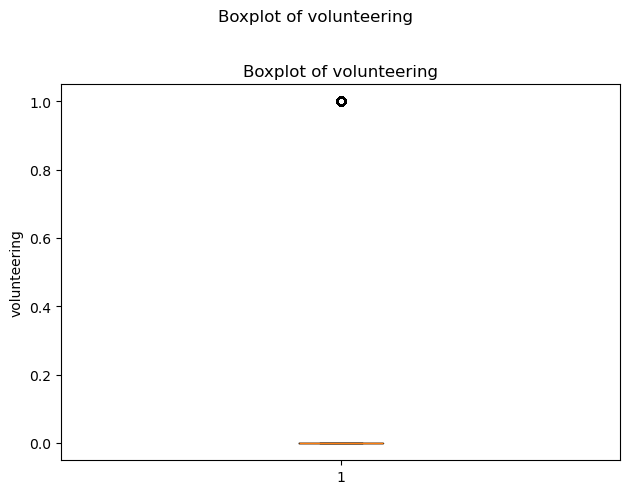

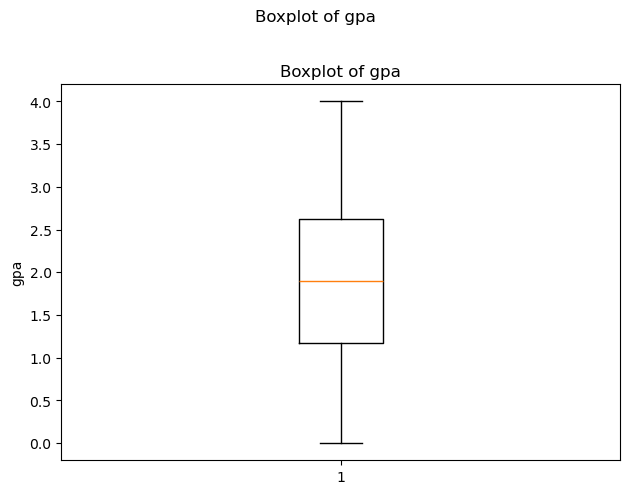

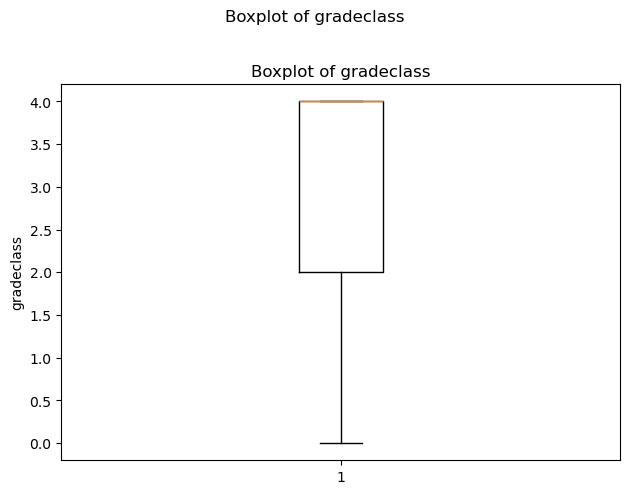


Correlation matrix (head):
                   studentid       age    gender  ethnicity  \
studentid           1.000000 -0.042255 -0.014625  -0.012990   
age                -0.042255  1.000000  0.044895  -0.028473   
gender             -0.014625  0.044895  1.000000   0.016010   
ethnicity          -0.012990 -0.028473  0.016010   1.000000   
parentaleducation  -0.002307  0.025099  0.006771   0.033595   

                   parentaleducation  studytimeweekly  absences  tutoring  \
studentid                  -0.002307         0.026976  0.014841 -0.007834   
age                         0.025099        -0.006800 -0.011511 -0.012076   
gender                      0.006771         0.011469  0.021479 -0.031597   
ethnicity                   0.033595         0.007184 -0.025712 -0.017440   
parentaleducation           1.000000        -0.011051  0.036518 -0.017340   

                   parentalsupport  extracurricular    sports     music  \
studentid                 0.003016        -0.003611 -0.

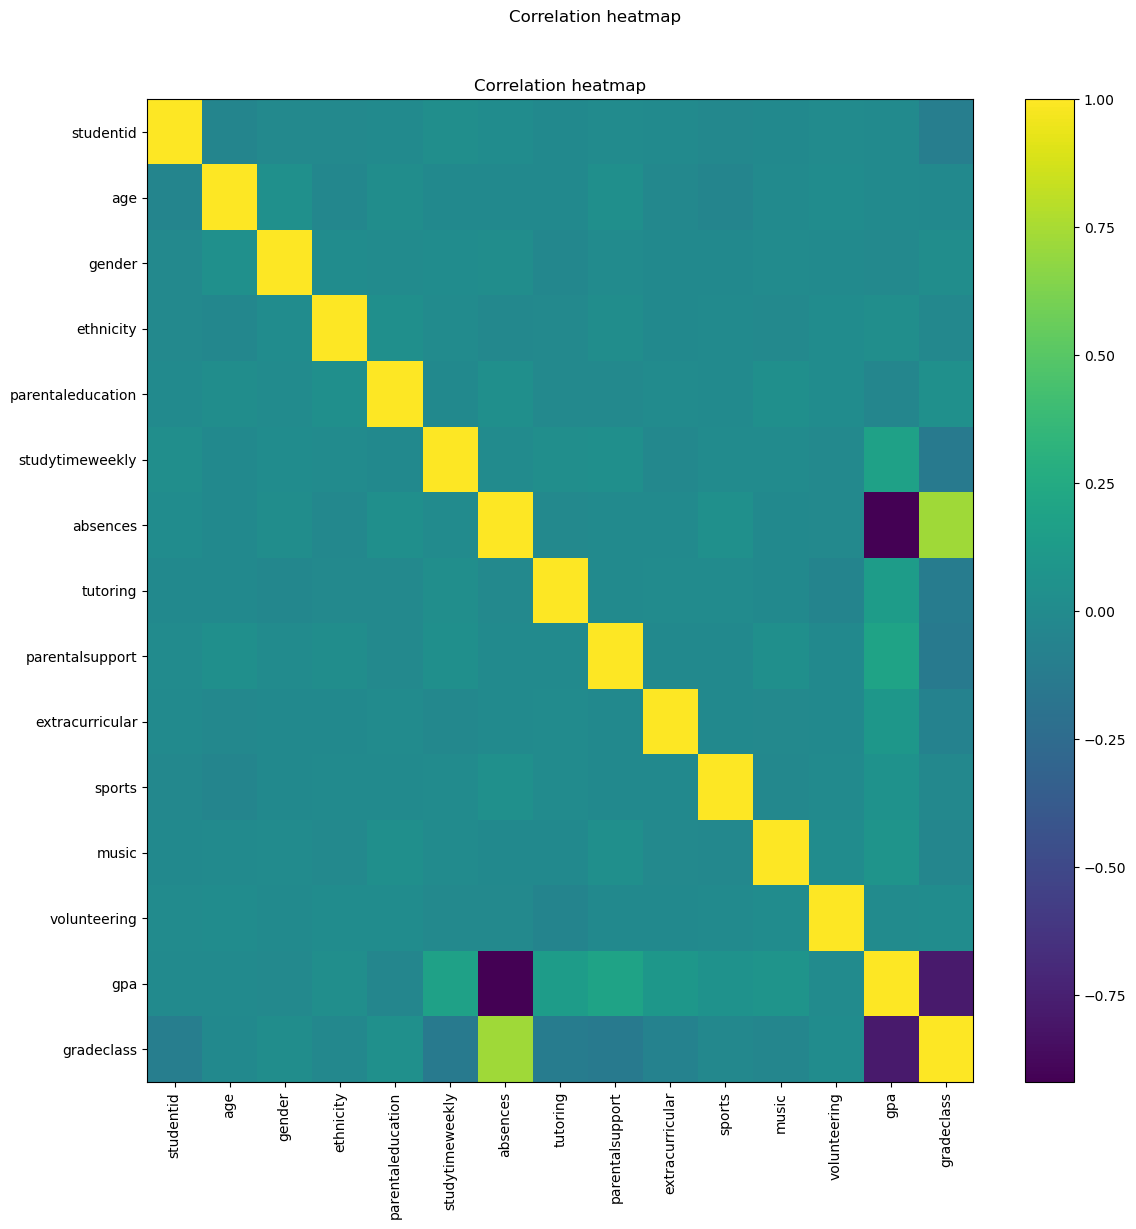

In [10]:


# ---------- Boxplots for numeric ----------
if num_cols:
    for c in num_cols:
        fig = plt.figure()
        plt.boxplot(df[c].dropna().values, vert=True)
        plt.title(f"Boxplot of {c}")
        plt.ylabel(c)
        save_or_show(fig, f"Boxplot of {c}")

# ---------- Correlation ----------
if len(num_cols) >= 2:
    corr = df[num_cols].corr(numeric_only=True)
    safe_show_df(corr, "Correlation matrix")

    fig = plt.figure(figsize=(0.6*len(num_cols)+3, 0.6*len(num_cols)+3))
    plt.imshow(corr, aspect="auto")
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.title("Correlation heatmap")
    plt.colorbar()
    save_or_show(fig, "Correlation heatmap")


Podemos ver que la variable GPA tiene una correlación negativa fuerte con gradeclass. Eso se debe a que la variable gradeclass nace de GPA al ser una clasificación de esta. Por ese motivo no vamos a considerar esta variable en el modelo.
Adicionalmente, gpa tiene una correlación negativa con las ausencias lo cual tiene mucho sentido.
Además, las variables studytimeweekly, tutoring y parentalsupport tienen una correlación negativa de 0.25.


Detected a likely target column: gradeclass

Correlation with gradeclass (head):
                   corr_with_target
absences                   0.728633
parentaleducation          0.041031
gender                     0.022998
volunteering               0.013156
age                       -0.006250


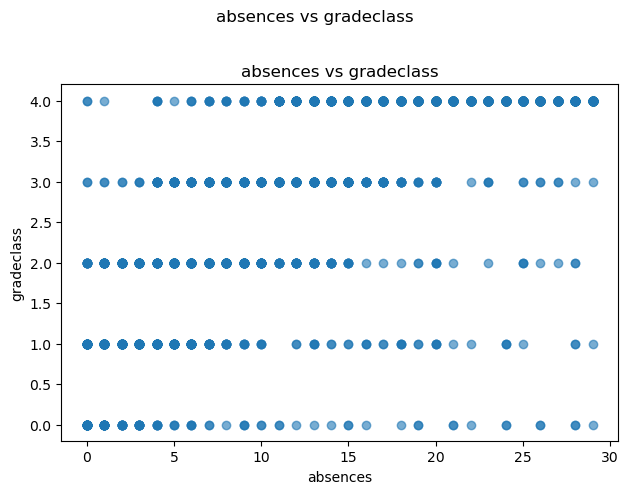

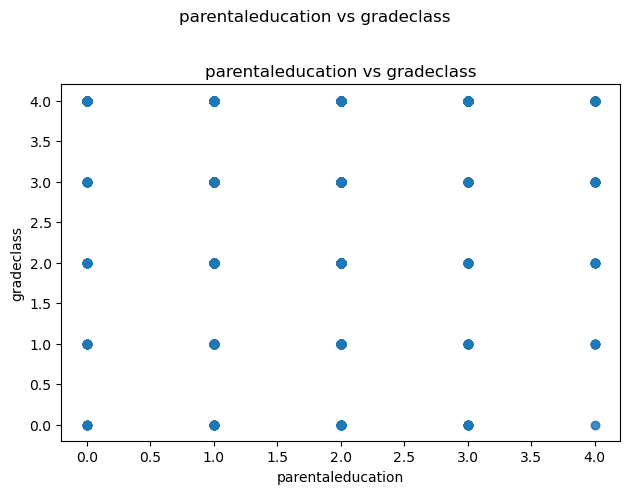

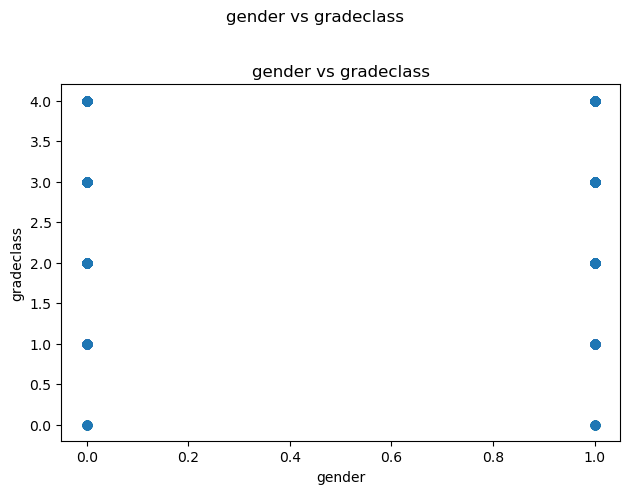

In [11]:
# ---------- Target-aware quick looks ----------
target = find_target(df, num_cols)
if target:
    print(f"\nDetected a likely target column: {target}")
    # Numeric predictors vs target
    others = [c for c in num_cols if c != target]
    if others:
        corrs = corr[target].drop(labels=[target]).sort_values(ascending=False)
        safe_show_df(corrs.to_frame("corr_with_target"), f"Correlation with {target}")

        # top scatter pairs
        top_pairs = corrs.dropna().head(3).index.tolist()
        for c in top_pairs:
            fig = plt.figure()
            plt.scatter(df[c], df[target], alpha=0.6)
            plt.xlabel(c)
            plt.ylabel(target)
            plt.title(f"{c} vs {target}")
            save_or_show(fig, f"{c} vs {target}")

    # Categorical group means of target
    for c in cat_cols:
        grp = df.groupby(c, dropna=False)[target].agg(["count", "mean"]).sort_values("mean", ascending=False).head(TOP_N_CATS)
        safe_show_df(grp, f"{c} groups ranked by mean {target}")

In [12]:
# ---------- Quick data quality notes ----------
notes = []
if mt["missing"].sum() > 0:
    notes.append("There are missing values. Consider imputation or dropping rows depending on column importance.")
if df.duplicated().sum() > 0:
    notes.append("There are duplicate rows. Consider deduplication if they are not expected.")
for c in num_cols:
    if df[c].min(skipna=True) == df[c].max(skipna=True):
        notes.append(f"Column {c} is constant. It can be dropped for modeling.")
if len(notes) == 0:
    notes.append("No immediate data quality red flags detected.")

print("\nData quality notes:")
for n in notes:
    print("-", n)

print("\nEDA complete.")


Data quality notes:
- No immediate data quality red flags detected.

EDA complete.
